In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
                             roc_curve, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import seaborn

In [2]:
all_player_stats = pd.read_csv('player_stats.csv')
all_player_stats.drop('Unnamed: 0', axis = 1, inplace = True)

## Data Cleaning

To resolve the issue of discrepancies in playing time among players, we will use per games statistics.

In [3]:
all_player_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4504 entries, 0 to 4503
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  4504 non-null   object 
 1   Pos     4504 non-null   object 
 2   G       4390 non-null   float64
 3   GS      3181 non-null   float64
 4   MP      4233 non-null   float64
 5   FG      4390 non-null   float64
 6   FGA     4390 non-null   float64
 7   FG%     4372 non-null   float64
 8   3P      3373 non-null   float64
 9   3PA     3373 non-null   float64
 10  3P%     2964 non-null   float64
 11  2P      3452 non-null   float64
 12  2PA     3452 non-null   float64
 13  2P%     3423 non-null   float64
 14  eFG%    3435 non-null   float64
 15  FT      4390 non-null   float64
 16  FTA     4390 non-null   float64
 17  FT%     4205 non-null   float64
 18  ORB     3630 non-null   float64
 19  DRB     3630 non-null   float64
 20  TRB     4274 non-null   float64
 21  AST     4390 non-null   float64
 22  

Keeping things consistent - some players played in the NBA, ABA, BAA so we're only considering those who played in the NBA and their respective NBA stats
Removed rows where all stats are blank (these are players who have never played in the NBA - only played in ABA or BAA)

In [4]:
subset = ['G','GS','MP','FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','FT','FTA','FT%','ORB','DRB','TRB',
          'AST','STL','BLK','TOV','PF','PTS']
all_player_stats.dropna(subset=subset,axis =0,inplace=True, how ='all') 

Some players are assigned multiple positions because they played different positions for different teams. Since we are using the positions as our targets, we will need to narrow it down to one. We will use the first assigned position listed since that is the position that the player held the most throughout their career.

In [5]:
all_player_stats.Pos.unique()

array(['Power Forward', 'Center and Power Forward', 'Center',
       'Point Guard', 'Shooting Guard',
       'Power Forward, Small Forward, and Center',
       'Small Forward and Power Forward', 'Guard', 'Small Forward',
       'Power Forward and Small Forward',
       'Shooting Guard and Small Forward',
       'Shooting Guard and Point Guard', 'Power Forward and Center',
       'Point Guard and Shooting Guard',
       'Shooting Guard, Small Forward, and Point Guard',
       'Small Forward and Shooting Guard', 'Forward',
       'Power Forward, Small Forward, Shooting Guard, and Point Guard',
       'Center/Forward', 'Guard/Forward', 'Forward/Center',
       'Small Forward and Point Guard',
       'Small Forward, Shooting Guard, and Power Forward',
       'Center, Power Forward, and Small Forward', 'Forward/Guard',
       'Small Forward, Power Forward, and Center',
       'Shooting Guard, Small Forward, and Power Forward',
       'Small Forward, Power Forward, and Shooting Guard',
     

Shooting Guard is the position with the most letters - can use this to filter for players that are assigned multiple positions. Only pull the first position

In [6]:
# players categorized with more than one position
all_player_stats[all_player_stats['Pos'].apply(len) > len('Shooting Guard')]

,Player,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
1,Zaid Abdul-Aziz,Center and Power Forward,505.0,NaN,21.8,3.5,8.2,0.428,NaN,NaN,...,0.728,2.4,5.4,8.0,1.2,0.6,1.0,0.9,2.2,9.0
5,Shareef Abdur-Rahim,"Power Forward, Small Forward, and Center",830.0,704.0,34.8,6.5,13.9,0.472,0.2,0.6,...,0.810,2.3,5.3,7.5,2.5,1.0,0.8,2.6,2.8,18.1
6,Tom Abernethy,Small Forward and Power Forward,319.0,NaN,17.0,2.3,4.6,0.492,0.0,0.0,...,0.747,1.2,2.0,3.2,1.2,0.6,0.2,0.5,1.6,5.6
14,Quincy Acy,Power Forward and Small Forward,337.0,60.0,16.0,1.7,3.9,0.444,0.5,1.6,...,0.759,0.9,2.6,3.5,0.6,0.4,0.4,0.6,2.0,4.9
15,Alvan Adams,Center and Power Forward,988.0,342.0,27.5,5.8,11.6,0.498,0.0,0.0,...,0.788,2.0,5.0,7.0,4.1,1.3,0.8,2.6,3.3,14.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4451,Brandan Wright,Power Forward and Center,428.0,62.0,16.2,3.0,4.9,0.607,0.0,0.0,...,0.674,1.4,2.3,3.6,0.5,0.5,1.0,0.5,1.3,7.0
4454,Delon Wright,Point Guard and Shooting Guard,319.0,54.0,20.9,2.8,6.2,0.451,0.7,1.9,...,0.795,0.8,2.4,3.2,3.1,1.1,0.4,1.0,1.2,7.6
4465,Tony Wroten,Point Guard and Shooting Guard,145.0,34.0,21.2,4.0,9.6,0.413,0.6,2.5,...,0.647,0.7,1.8,2.5,3.0,0.9,0.2,2.6,1.8,11.1
4481,Sam Young,Small Forward and Shooting Guard,249.0,52.0,15.9,2.2,5.1,0.442,0.2,0.7,...,0.742,0.7,1.6,2.3,0.7,0.5,0.2,0.8,1.2,5.8


In [7]:
# players categorized one position
all_player_stats[all_player_stats['Pos'].apply(len) <= len('Shooting Guard')]

,Player,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Alaa Abdelnaby,Power Forward,256.0,53.0,12.5,2.4,4.8,0.502,0.0,0.0,...,0.701,1.1,2.2,3.3,0.3,0.3,0.3,1.0,1.9,5.7
2,Kareem Abdul-Jabbar,Center,1560.0,625.0,36.8,10.2,18.1,0.559,0.0,0.0,...,0.721,2.4,7.6,11.2,3.6,0.9,2.6,2.7,3.0,24.6
3,Mahmoud Abdul-Rauf,Point Guard,586.0,336.0,26.7,6.0,13.6,0.442,0.8,2.3,...,0.905,0.4,1.5,1.9,3.5,0.8,0.1,1.6,1.9,14.6
4,Tariq Abdul-Wahad,Shooting Guard,236.0,145.0,20.4,3.1,7.3,0.417,0.1,0.3,...,0.703,1.2,2.1,3.3,1.1,0.8,0.4,1.3,2.1,7.8
7,Forest Able,Guard,1.0,NaN,1.0,0.0,2.0,0.000,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4499,Paul Zipser,Small Forward,98.0,30.0,17.0,1.7,4.6,0.371,0.7,2.1,...,0.769,0.3,2.3,2.6,0.8,0.4,0.3,0.8,1.7,4.7
4500,Ante Žižić,Center,113.0,27.0,13.4,2.4,4.2,0.581,0.0,0.0,...,0.711,1.3,2.6,3.9,0.6,0.2,0.4,0.7,1.5,6.0
4501,Jim Zoet,Center,7.0,0.0,4.3,0.1,0.7,0.200,0.0,0.0,...,NaN,0.4,0.7,1.1,0.1,0.1,0.4,0.6,1.3,0.3
4502,Bill Zopf,Point Guard,53.0,NaN,7.5,0.9,2.5,0.363,NaN,NaN,...,0.556,NaN,NaN,0.9,1.4,NaN,NaN,NaN,0.6,2.2


Below code takes care of the rows that have multiple positions listed out with commas, have ands or slashes - more cleaning need to be done
Cannot split by '/' and remove with the below code - need both positions to decide what position it is (i.e. if we take the first position it might generically say guard - won't know which guard, second position gives us more insight. Guard/Forward -> Shooting Guard)

In [8]:
# Takes care of the rows that have multiple positions listed out with commas, have ands or slashes - more cleaning need to be done
all_player_stats['Target'] = all_player_stats['Pos'].apply(lambda x: x.split(',')[0] if ',' in x else x.split(',')[0].split(' and ')[0])


In [9]:
all_player_stats['Target'].unique()

array(['Power Forward', 'Center', 'Point Guard', 'Shooting Guard',
       'Small Forward', 'Guard', 'Forward', 'Center/Forward',
       'Guard/Forward', 'Forward/Center', 'Forward/Guard',
       'Point Guard\n'], dtype=object)

There are 156 players that are categorized generically as a guard or a forward - hard to put them in a position without looking at them individually and make judgement calls on my end. Will be dropping these players from the dataset which is only about 3.4%

In [10]:
index = all_player_stats.index
condition = (all_player_stats['Target']=='Guard') | (all_player_stats['Target']=='Forward')
rows_to_drop_indices = index[condition]
all_player_stats.drop(rows_to_drop_indices, axis = 0, inplace=True)

In [11]:
all_player_stats['Target'].unique()

array(['Power Forward', 'Center', 'Point Guard', 'Shooting Guard',
       'Small Forward', 'Center/Forward', 'Guard/Forward',
       'Forward/Center', 'Forward/Guard', 'Point Guard\n'], dtype=object)

Further cleaning the Target column - classifying those with '/' with the first position and changing guard to the corresponding position etc.

In [12]:
all_player_stats.replace(['Center/Forward','Guard/Forward','Forward/Center','Forward/Guard','Point Guard\n'],
                        ['Center', 'Shooting Guard','Power Forward', 'Small Forward', 'Point Guard'], inplace = True)

In [13]:
# Targets look good
all_player_stats['Target'].unique()

array(['Power Forward', 'Center', 'Point Guard', 'Shooting Guard',
       'Small Forward'], dtype=object)

Add in another feature: 1 - multiple positions, 0 - single position, see if this improves out model. Only meant to use informatively, cannot use for final model! It would be cheating!

In [37]:
all_player_stats['Num_Pos'] = all_player_stats['Pos'].apply(len) > len('Shooting Guard')
classify = {True:1, False:0}
all_player_stats['Num_Pos'] = all_player_stats['Num_Pos'].map(classify)

In [192]:
all_player_stats.head()

,Player,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Target,Num_Pos
0,Alaa Abdelnaby,Power Forward,256.0,53.0,12.5,2.4,4.8,0.502,0.0,0.0,...,2.2,3.3,0.3,0.3,0.3,1.0,1.9,5.7,Power Forward,0
1,Zaid Abdul-Aziz,Center and Power Forward,505.0,NaN,21.8,3.5,8.2,0.428,NaN,NaN,...,5.4,8.0,1.2,0.6,1.0,0.9,2.2,9.0,Center,1
2,Kareem Abdul-Jabbar,Center,1560.0,625.0,36.8,10.2,18.1,0.559,0.0,0.0,...,7.6,11.2,3.6,0.9,2.6,2.7,3.0,24.6,Center,0
3,Mahmoud Abdul-Rauf,Point Guard,586.0,336.0,26.7,6.0,13.6,0.442,0.8,2.3,...,1.5,1.9,3.5,0.8,0.1,1.6,1.9,14.6,Point Guard,0
4,Tariq Abdul-Wahad,Shooting Guard,236.0,145.0,20.4,3.1,7.3,0.417,0.1,0.3,...,2.1,3.3,1.1,0.8,0.4,1.3,2.1,7.8,Shooting Guard,0


## Prelim EDA

In [191]:
all_player_stats.describe()

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Num_Pos
count,4234.000000,3181.000000,4142.000000,4234.000000,4234.000000,4217.000000,3372.000000,3372.000000,2963.000000,3450.000000,...,3629.000000,3629.000000,4165.000000,4234.000000,3601.000000,3601.000000,3463.000000,4234.000000,4234.000000,4234.000000
mean,295.242088,141.156869,16.821704,2.542844,5.857865,0.420155,0.345907,1.041044,0.248714,2.190029,...,0.877074,2.030973,3.052725,1.493269,0.553430,0.321161,1.051516,1.784766,6.655007,0.304676
std,316.689540,235.404736,8.918755,1.848600,3.919277,0.095464,0.499318,1.343152,0.155824,1.742169,...,0.707429,1.504986,2.289070,1.402677,0.399034,0.382168,0.691169,0.844228,4.868962,0.460325
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,0.000000,9.500000,1.200000,2.900000,0.383000,0.000000,0.000000,0.152000,0.900000,...,0.400000,0.900000,1.400000,0.500000,0.300000,0.100000,0.600000,1.100000,3.000000,0.000000
50%,153.000000,22.000000,15.900000,2.100000,4.900000,0.430000,0.100000,0.400000,0.286000,1.700000,...,0.700000,1.700000,2.500000,1.100000,0.500000,0.200000,0.900000,1.800000,5.400000,0.000000
75%,501.750000,178.000000,23.400000,3.400000,8.000000,0.469000,0.500000,1.700000,0.348000,3.000000,...,1.200000,2.700000,4.100000,2.000000,0.800000,0.400000,1.400000,2.400000,9.000000,1.000000
max,1611.000000,1471.000000,45.800000,12.100000,23.800000,1.000000,3.700000,8.500000,1.000000,10.800000,...,5.100000,10.500000,22.900000,11.200000,2.700000,3.500000,4.200000,5.000000,30.100000,1.000000


From the above chart it shows min games played by someone is 1 game! Should drop players that only played a few games since stats are per game. Data is total career averages - those who played very litte games, the data might not be representative of their true performance i.e. could be a rookie (since this is career total for all basketball players thus far which includes current rookies, or it could be a 10-day contract deal like Antonio Anderson had done with OKC). Per season - each team plays 82 games.

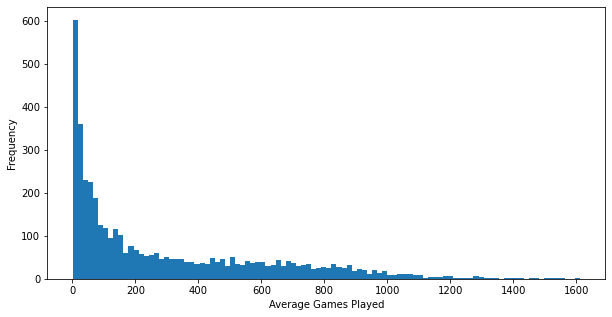

In [193]:
all_player_stats['G'].hist(grid=False,bins=100,figsize=(10,5))
plt.xlabel('Average Games Played')
plt.ylabel('Frequency');

Looking at the distribution of average games played - there isn't an obvious threshold of min games played to consider. Doing intuitively - given that there are 82 games in a season, and not all players play for the whole game, I would say drop players that have played <20 games (~ 1/4 of a season)

In [201]:
# dropping players that played less than 20 games in their total career
all_player_stats = all_player_stats[all_player_stats['G'] >=20]

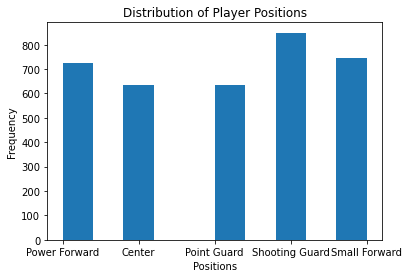

In [202]:
# Positions are pretty evenly distributed
fig,ax = plt.subplots()
ax.hist(all_player_stats['Target'])
ax.set_xlabel('Positions')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Player Positions');

In [203]:
summary = all_player_stats.groupby('Target').mean()

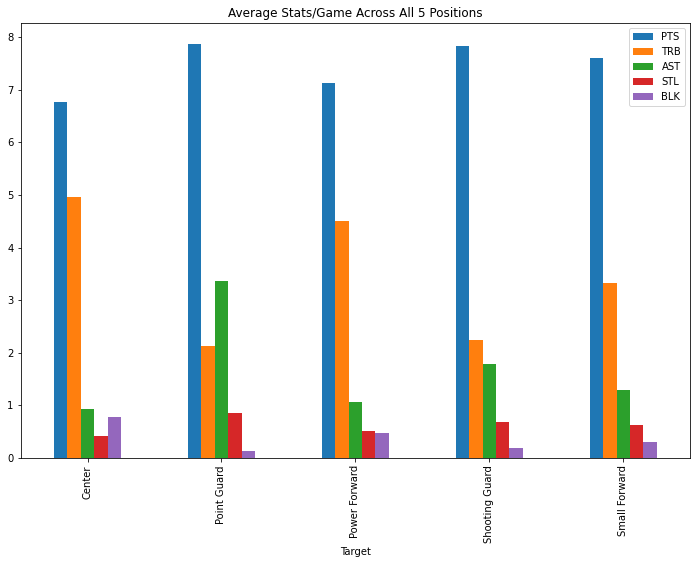

In [204]:
bar_chart_df = summary[['PTS', 'TRB', 'AST', 'STL', 'BLK']]
bar_chart_df.plot(kind='bar', figsize = (12, 8), title='Average Stats/Game Across All 5 Positions');

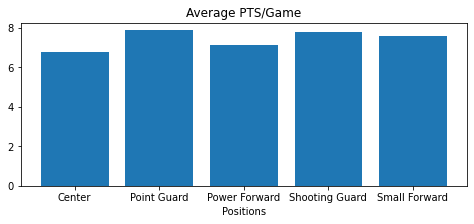

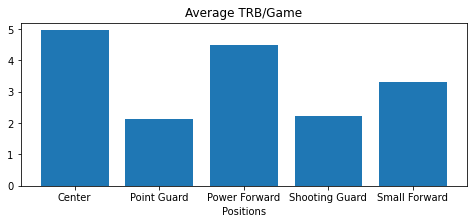

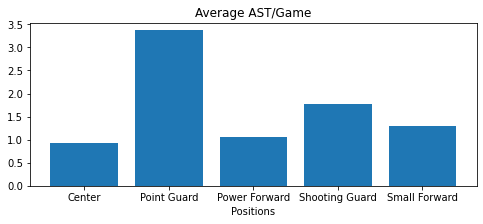

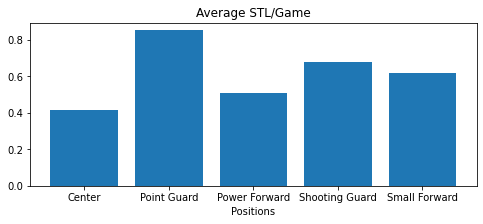

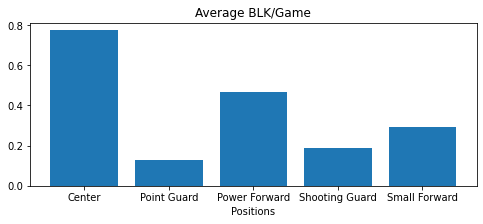

In [205]:
for feature in ['PTS', 'TRB', 'AST', 'STL', 'BLK']:
    fig, ax = plt.subplots(figsize = (8,3))
    ax.bar(summary.index, summary[feature])
    ax.set_xlabel('Positions')
    ax.set_title(f'Average {feature}/Game');

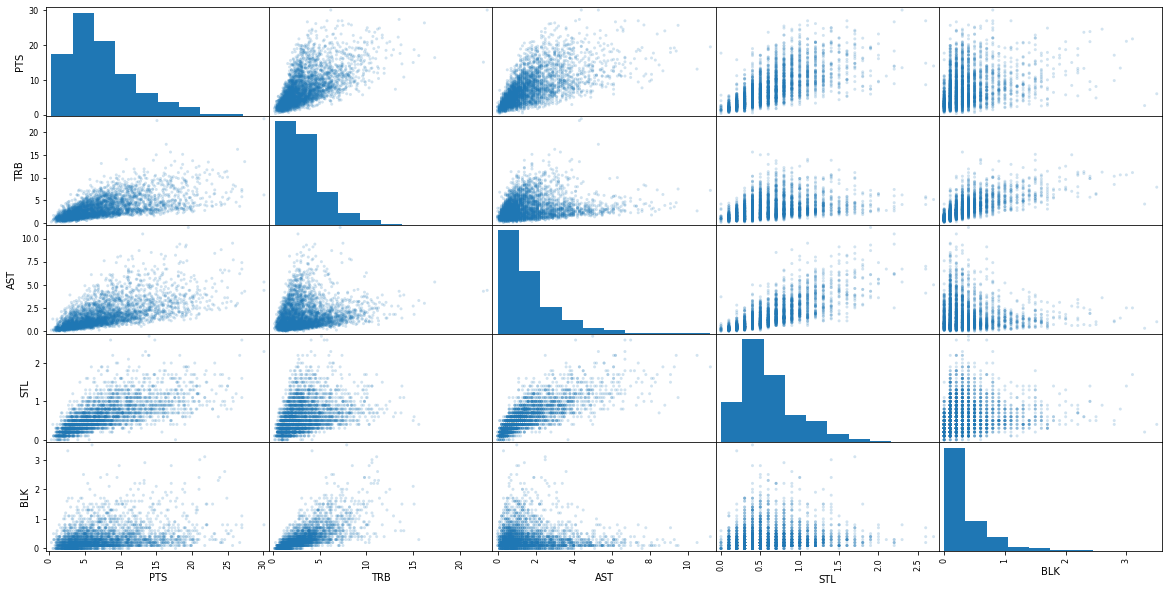

In [206]:
pd.plotting.scatter_matrix(all_player_stats[['PTS', 'TRB', 'AST', 'STL', 'BLK']], alpha=0.2, figsize = (20,10));

### Create baseline model with the main 5 stats and drop NaNs for ease - can revisit how to deal with NaNs

In [207]:
# check how many rows have NaNs
is_NaN = all_player_stats[['PTS', 'TRB', 'AST', 'STL', 'BLK']].isnull()
row_has_NaN = is_NaN.any(axis=1)
row_has_NaN.sum()

566

In [208]:
# percent we would be dropping
(633/all_player_stats.shape[0]) * 100

17.637224853719697

Dropping NaNs and try creating a base model with the 5 main stats first then move forward from there

In [210]:
# dropping rows with NaNs
no_nan_all_stats = all_player_stats.dropna(axis=0)

X = no_nan_all_stats[['PTS', 'TRB', 'AST', 'STL', 'BLK']]
y = no_nan_all_stats['Target']

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 23, stratify = y)

In [252]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 10).fit(X_train,y_train)
print(f'train accuracy: {cross_val_score(rf,X_train,y_train,cv=5).mean()} | test accuracy: {rf.score(X_test,y_test)}')

train accuracy: 0.639 | test accuracy: 0.642


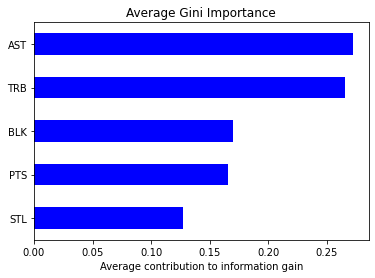

In [214]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X_train.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh',
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

The areas that the model is misclassifying make sense given a lot of Centers are interchangeable with Power Forwards, same with Shooting Guards and Small Forwards - these classifications would be interchangeable if done by hand as well - in this case, what would be the defining features that distinguish a Center from a Power Forward. What feature can we add into our model to inform the classifcation better?

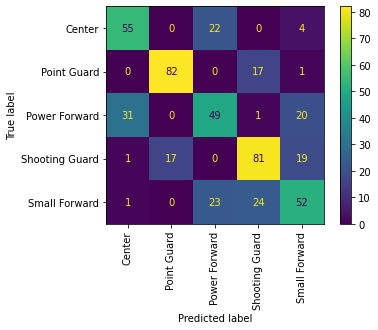

In [215]:
plot_confusion_matrix(rf,X_test,y_test,xticks_rotation='vertical');

Investigate to see who we are getting wrong - i.e. LeBron James is technically a unicorn and play almost all positions.

Try adding in the bool column (1-multiple positions, 0-single position) to see if that is telling of anything

In [216]:
X2 = no_nan_all_stats[['PTS', 'TRB', 'AST', 'STL', 'BLK','Num_Pos']]
y2 = no_nan_all_stats['Target']

# split data into training and testing
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size = 0.20, random_state = 23, stratify = y)

The boolean column did not inform anything new - performance is similar with or without the added column 

In [218]:
rf2 = RandomForestClassifier(n_estimators = 500, max_depth = 10).fit(X_train2,y_train2)
print(f'train accuracy: {cross_val_score(rf2,X_train2,y_train2,cv=5).mean()} | test accuracy cross val: {rf2.score(X_test2,y_test2)}')

train accuracy: 0.643 | test accuracy cross val: 0.642


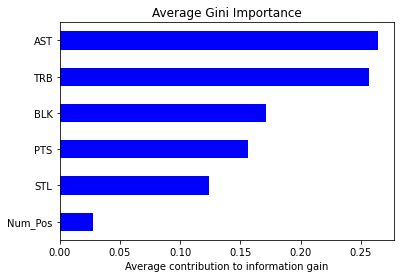

In [219]:
# Plot the feature importance
feat_scores = pd.Series(rf2.feature_importances_,
                           index=X_train2.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh',
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

What are the defining features for each position? What distinguishes someone from being a Center/Power Forward or Shooting Guard/Small Forward - since there is so much overlap between these.

In [250]:
def ROC(model, X_test, y_test):

    Predicted_prob = model.predict_proba(X_test)
    fig, axs = plt.subplots(1,2, figsize=(18.75,10))
    y_test_dummy = pd.get_dummies(y_test).values
    targets = ['Power Forward', 'Center', 'Point Guard', 'Shooting Guard',
       'Small Forward']
    for i in range(5):
        # ROC Curve
        fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob[:,i])
        axs[0].plot(fpr,tpr,lw=3,label=targets[i])#,color=colors[i])
        axs[0].plot([0,1],[0,1],color='k',ls='--')
        axs[0].set_xlabel('False Positive Rate')
        axs[0].set_ylabel('True Positive Rate')
        axs[0].legend()
        axs[0].set_title('ROC Curve')
        # Precision-Recall Curve
        precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob[:,i])
        axs[1].plot(recall,precision,label=targets[i])#,color=colors[i])
        axs[1].set_xlabel('Recall')
        axs[1].set_ylabel('Precision')
        axs[1].set_title('Precision-Recall Curve')
        axs[1].legend() 

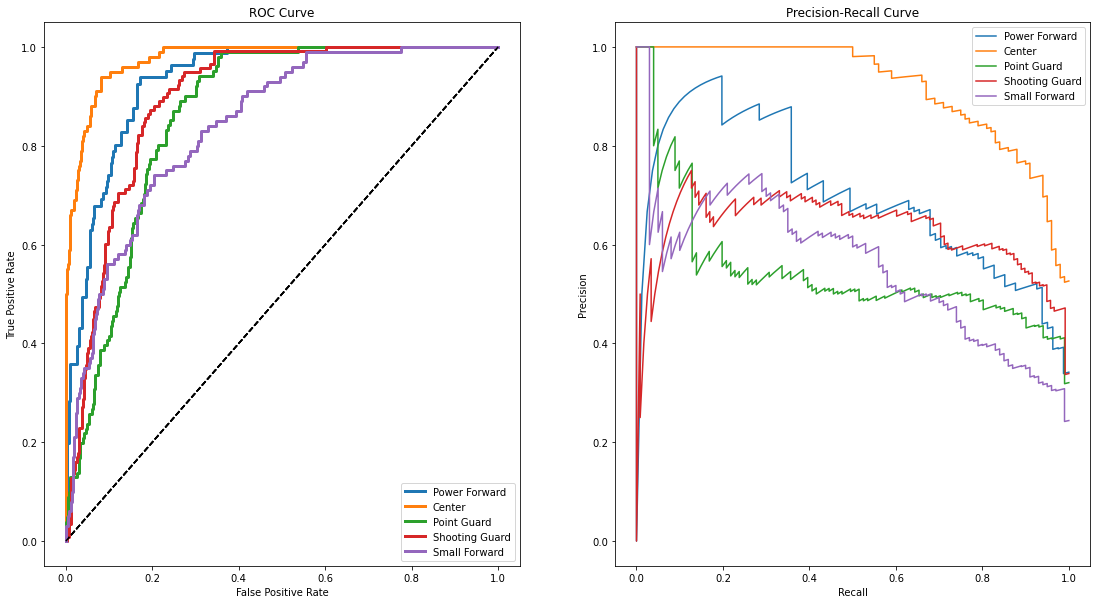

In [251]:
ROC(rf, X_test, y_test)